In [1]:
%tensorflow_version 1.14
!pip install DCASE-models==0.2.0-rc0



`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
  Using cached Keras-2.2.4-py2.py3-none-any.whl (312 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


We will need to have sox installed

In [2]:
!apt-get install libsox-fmt-all libsox-dev sox 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsox-dev is already the newest version (14.4.2-3ubuntu0.18.04.1).
libsox-fmt-all is already the newest version (14.4.2-3ubuntu0.18.04.1).
sox is already the newest version (14.4.2-3ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


Import the libraries

In [3]:
import os
import json
import warnings    
import sys
import numpy as np
rootdir_path = '/tmp/'
sys.path.append(rootdir_path)

# Datasets
from dcase_models.data.datasets import ESC10,ESC50,URBAN_SED
from dcase_models.util.files import load_json

# Features
from dcase_models.data.features import MelSpectrogram

from dcase_models.data.data_generator import DataGenerator
from dcase_models.data.scaler import Scaler
from dcase_models.util.files import load_json, load_pickle
from dcase_models.util.files import mkdir_if_not_exists, save_pickle
from dcase_models.util.data import evaluation_setup
from dcase_models.model.container import KerasModelContainer

from keras.layers import Layer


Using TensorFlow backend.


#Datasets

### Dataset download

Download the ESC dataset.
First initialize the dataset. 

In [4]:
!find /tmp -ctime +10 -exec rm -rf {} +

In [6]:
dataset_name = 'ESC10'
dataset = ESC10(os.path.join(rootdir_path, dataset_name))
# dataset_name = 'ESC50'
# dataset = ESC50(os.path.join(rootdir_path, dataset_name))
# dataset_name = 'URBAN_SED'
# dataset = URBAN_SED(rootdir_path)

Then call the download method. 

In [7]:
if dataset.check_if_downloaded():
    print(dataset_name+' dataset was already downloaded. ')
else:
    print('downloading '+dataset_name)
    dataset.download()
dataset.build()

downloading ESC10
Done!
Extracting file:  /tmp/ESC10/ESC-50-master.zip
Done!


In [8]:
#!ls "$rootdir_path/"
print(dataset.label_list)

['dog', 'rooster', 'rain', 'sea_waves', 'crackling_fire', 'crying_baby', 'sneezing', 'clock_tick', 'helicopter', 'chainsaw']


# Model evaluation

We clone the github repository corresponding to this paper:

*Zinemanas, P.; Rocamora, M.; Fonseca, E.; Font, F.; Serra, X. Toward interpretable polyphonic sound event detection with attention maps based on local prototypes. Proceedings of the Detection and Classification of Acoustic Scenes and Events 2021 Workshop (DCASE2021). Barcelona, Spain.*

In [9]:
!git clone https://github.com/pzinemanas/attprotos.git

Cloning into 'attprotos'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 138 (delta 17), reused 127 (delta 12), pack-reused 0
Receiving objects: 100% (138/138), 40.11 MiB | 23.48 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [10]:
!ls attprotos/experiments/URBAN_SED/AttProtos
!ls attprotos/attprotos
sys.path.append("attprotos/attprotos")

config.json  test_1   test_2  test_4  test_6  test_8
test	     test_10  test_3  test_5  test_7  test_9
features.py  __init__.py  layers.py  losses.py	model.py


In [11]:
import attprotos
from attprotos import attprotos
from attprotos.attprotos.layers import PrototypeReconstruction
from attprotos.attprotos.losses import prototype_loss
from attprotos.attprotos.model import AttProtos
from attprotos.attprotos.features import Openl3

In [12]:
models_path = 'attprotos/experiments'
fold_name = 'test'
attn_dataset_name = 'URBAN_SED'
train_dataset = URBAN_SED(rootdir_path)

model_folder = os.path.join(models_path, attn_dataset_name, "AttProtos")
parameters_file = os.path.join(model_folder, 'config.json')
params = load_json(parameters_file)
print(params)

# # if you are not using Attprotos, load all parameters from json file
# !rm "$rootdir_path"/parameters.json
# !wget https://github.com/MTG/DCASE-models/raw/master/parameters.json -P "$rootdir_path"
# params = load_json(os.path.join(rootdir_path, 'parameters.json'))


{'features': {'MelSpectrogram': {'sequence_time': 1.0, 'sequence_hop_time': 1.0, 'audio_hop': 1070, 'audio_win': 4096, 'sr': 22050, 'mel_bands': 128, 'n_fft': 4096, 'pad_mode': 'none'}}, 'train': {'early_stopping': 100, 'epochs': 50, 'considered_improvement': 0.0, 'learning_rate': 0.001, 'batch_size': 256, 'verbose': 1, 'optimizer': 'Adam'}, 'models': {'AttProtos': {'normalizer': 'minmax', 'model_arguments': {'filter_size_cnn': [5, 5], 'distance': 'euclidean', 'use_weighted_sum': 1, 'n_prototypes': 15}, 'train_arguments': {'loss_weights': [10, 5, 0, 5], 'init_last_layer': 0}}}, 'datasets': {'URBAN_SED': {'dataset_path': '../../DCASE-models/datasets/URBAN-SED_v2.0.0', 'evaluation_mode': 'train-validate-test'}}}


####Feature extraction 

Check the feature extraction parameters

In [13]:
params_features = params['features']["MelSpectrogram"]
if params_features['pad_mode'] == 'none':
    params_features['pad_mode'] = None

params_dataset = params['datasets'][attn_dataset_name]
params_model = params['models']["AttProtos"]

Check if the parameters are correct

In [14]:
# print feature extraction parameters 
print(json.dumps(params_features, indent=4, sort_keys=True))

{
    "audio_hop": 1070,
    "audio_win": 4096,
    "mel_bands": 128,
    "n_fft": 4096,
    "pad_mode": null,
    "sequence_hop_time": 1.0,
    "sequence_time": 1.0,
    "sr": 22050
}


Define the feature extractor

In [15]:
# Get and init feature class
features = MelSpectrogram(**params_features)

### if you don't use Attprotos use this
# features =  MelSpectrogram(sequence_time=params_features['sequence_time'],
#                            sequence_hop_time=params_features['sequence_hop_time'], 
#                            audio_win=params_features['audio_win'], 
#                            audio_hop=params_features['audio_hop'],
#                            sr=params_features['sr'], 
#                            **params_features['MelSpectrogram'])

Check if the features were extracted and if not, extract them

In [16]:
# Extract features
if features.check_if_extracted(dataset):
    print('Features were already extracted. ')
else:
    print('Extracting features ...')
    features.extract(dataset)

print('Done!')
print('Features shape: ', features.get_shape(10.0))


Extracting features ...
Changing sampling rate ...

Done!

Done!
Features shape:  (10, 20, 128)


#### Model loading

We load the already trained model AttProtos from the corresponding folder. We also initialzie the dataloader to get the correct parameters for the experiments used to train this dataset. 

In [17]:
exp_folder = os.path.join(model_folder, fold_name)

# Load scaler
scaler_file = os.path.join(exp_folder, 'scaler.pickle')
scaler = load_pickle(scaler_file)

# Init data generator
data_gen_test = DataGenerator(
    dataset, features, folds=['fold1'],
    batch_size=params['train']['batch_size'],
    shuffle=False, train=False, scaler=scaler
)

metrics = ['sed']

features_shape = features.get_shape()
n_frames_cnn = features_shape[1]
n_freq_cnn = features_shape[2]
n_classes = len(train_dataset.label_list)
print(features_shape,n_frames_cnn,n_freq_cnn,n_classes)

model_container = AttProtos(
    model=None, model_path=None, n_classes=n_classes,
    n_frames_cnn=n_frames_cnn, n_freq_cnn=n_freq_cnn,
    metrics=metrics,
    **params_model['model_arguments']
)

model_container.load_model_weights(exp_folder)



(10, 20, 128) 20 128 10













We can print a summary of the modules in the deep learning model. Note the prototypes layers which are interpretable. 

In [18]:
model_container.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 20, 128)      0                                            
__________________________________________________________________________________________________
encoder_mask (Model)            (None, 5, 32, 15)    38479       input[0][0]                      
__________________________________________________________________________________________________
encoder (Model)                 [(None, 5, 32, 32),  52096       input[0][0]                      
__________________________________________________________________________________________________
sum (Lambda)                    (None, 32, 15)       0           encoder_mask[1][0]               
__________________________________________________________________________________________________
lc (Protot

We get one training example to obtain a prediction

In [19]:
print(data_gen_test.audio_file_list)
X, Y = data_gen_test.get_data()

[{'file_original': '/tmp/ESC10/audio/1-28135-B-11.wav', 'sub_folder': 'original'}, {'file_original': '/tmp/ESC10/audio/1-19898-B-41.wav', 'sub_folder': 'original'}, {'file_original': '/tmp/ESC10/audio/1-47250-A-41.wav', 'sub_folder': 'original'}, {'file_original': '/tmp/ESC10/audio/1-40730-A-1.wav', 'sub_folder': 'original'}, {'file_original': '/tmp/ESC10/audio/1-44831-A-1.wav', 'sub_folder': 'original'}, {'file_original': '/tmp/ESC10/audio/1-46272-A-12.wav', 'sub_folder': 'original'}, {'file_original': '/tmp/ESC10/audio/1-17367-A-10.wav', 'sub_folder': 'original'}, {'file_original': '/tmp/ESC10/audio/1-39901-A-11.wav', 'sub_folder': 'original'}, {'file_original': '/tmp/ESC10/audio/1-64398-B-41.wav', 'sub_folder': 'original'}, {'file_original': '/tmp/ESC10/audio/1-4211-A-12.wav', 'sub_folder': 'original'}, {'file_original': '/tmp/ESC10/audio/1-28135-A-11.wav', 'sub_folder': 'original'}, {'file_original': '/tmp/ESC10/audio/1-34119-B-1.wav', 'sub_folder': 'original'}, {'file_original': '

What classes we have in this dataset?

In [20]:
print(dataset.label_list)

['dog', 'rooster', 'rain', 'sea_waves', 'crackling_fire', 'crying_baby', 'sneezing', 'clock_tick', 'helicopter', 'chainsaw']


These are the classes for which the model has been trained for

In [21]:
model_classes=['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
print(model_classes)

['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


In [22]:
#instance = 8 #dog
instance = 5 #chainsaw
#instance = 6 #waves

filename = data_gen_test.audio_file_list[instance]['file_original'].split(os.path.sep)[-1]
print(filename)
print(dataset.metadata[filename])

import IPython.display as ipd
audio = data_gen_test.audio_file_list[instance]['file_original']
sr = params_features['sr']
ipd.Audio(audio,rate=sr)


1-46272-A-12.wav
{'fold': 'fold1', 'class_ix': 4, 'class_name': 'crackling_fire', 'esc10': True}


In [23]:
pred = model_container.model.predict(X[instance])[0]
print(np.argmax(pred,axis=1))
print(np.mean(pred,axis=0))
print(model_classes[np.argmax(np.mean(pred,axis=0))])
predicted_class = np.argmax(np.mean(pred,axis=0))

[5 5 5 5 5]
[0.20139332 0.00520398 0.15663318 0.04944126 0.5327095  0.8314344
 0.06896665 0.24943845 0.00903049 0.07508326]
engine_idling


Let's look at the model interpretability.
We plot the mel spectrogram and the spectrogram reconstructed with the autoencoder. 

(5, 20, 128) (5, 10)


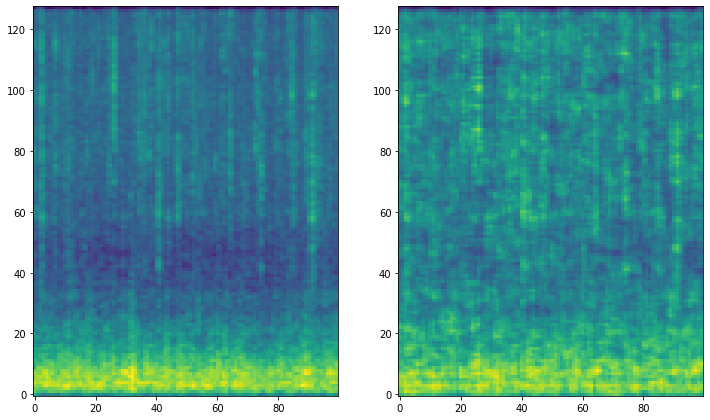

In [24]:
import matplotlib.pyplot as plt 

h, mask1, mask2 = model_container.model_encoder.predict(X[instance])
alpha = model_container.model_encoder_mask.predict(X[instance])

H_hat, _ = model_container.model_h_hat().predict(X[instance])
X_hat = model_container.model_decoder.predict([H_hat, mask1, mask2])

print(X_hat.shape, pred.shape)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(np.concatenate(X[instance], axis=0).T, origin='lower')
plt.subplot(1,2,2)
plt.imshow(np.concatenate(X_hat, axis=0).T, origin='lower')
plt.show()


Prototypes may be used to reconstruct the original signal. In this case we can build a saliency maps to see which areas in the mel spectrogram are more salient for a particular class. Here we use the predicted class. Let's first plot the original spectrogram. 

crying_baby
(5, 32, 15)
(5, 32, 15)
(100, 128)


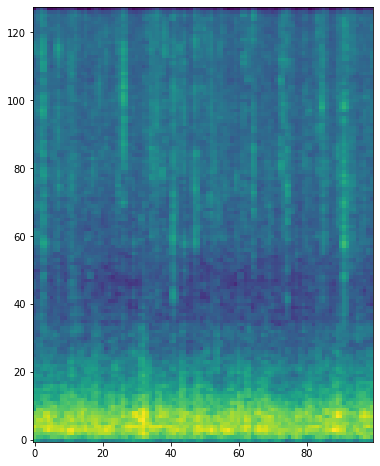

In [25]:
import matplotlib.gridspec as grd

class_ix = predicted_class

print(dataset.label_list[class_ix])

time_hops = np.argwhere(pred[:,class_ix]*(pred[:,class_ix]>0.5)!=0)

logits = pred
mask_logits = np.zeros_like(logits)

mask_logits[time_hops, class_ix] = 1

logits = logits*mask_logits

w = model_container.model.get_layer('dense').get_weights()[0]

grad = logits.dot(w.T)
_, C, F = model_container.model.get_layer('sum').output_shape
grad = np.reshape(grad, (len(logits), C, F))
print(grad.shape)

alpha2 = np.sum(alpha, axis=1)
print(alpha2.shape)

alpha_grad = grad*alpha2
alpha_grad = alpha_grad*(alpha_grad>0)


data = np.concatenate(X[instance], axis=0)
print(data.shape)
saliency = np.zeros_like(data)

for th in time_hops:
    energy = np.sum(alpha_grad[th[0]]**2, axis=0)
    profile = alpha_grad[th[0], :, np.argmax(energy)]
    
    profile_extend = np.interp(np.arange(128), np.arange(32)*4, profile)

    profile_extend = np.convolve(profile_extend, [1/32]*32, mode='same')

    #plt.plot(profile_extend)
    #plt.show()

    saliency[th[0]*20:(th[0] + 1)*20] = profile_extend

plt.figure(figsize=(12,8))

#fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True,figsize=(12,8))

#saliency = np.ma.masked_where((0.0 < saliency) & 
#                             (saliency < 10), saliency)

#saliency = saliency*(saliency>0.1)

plt.imshow(data.T, origin='lower')

#ax = plt.subplot(gs[1])
#ax[1].imshow((pred*(pred>0.5)).T, origin='lower', interpolation='nearest', extent=[0, 200, 0, 10])
plt.show()


Let's plot the saliency map. 

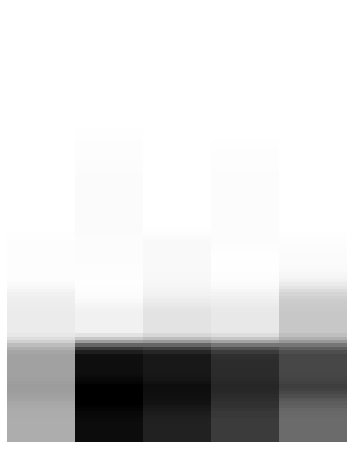

In [26]:
plt.figure(figsize=(12,8))
plt.imshow(saliency.T, origin='lower', cmap ='gist_yarg')
plt.axis('off')
plt.show()

If we multiply the saliency map with the mel spectrogam we can see the attention map associated with the input image. This can give some information about which parts of the mel spectrogram are important according to the learnt prototypes.

(100, 128)


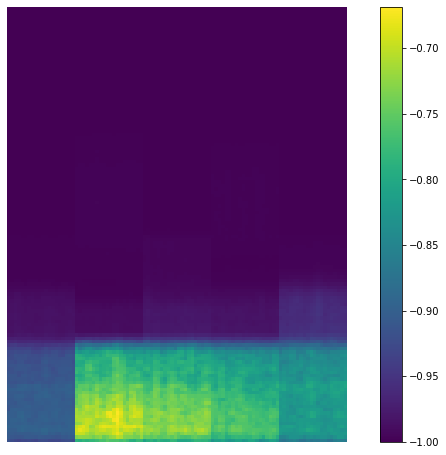

In [27]:
plt.figure(figsize=(12,8))
masked_data = 2*((data+1)*saliency/2) - 1
print(masked_data.shape)
#masked_data[np.abs(masked_data)<0.01] = -1
plt.imshow(masked_data.T, origin='lower')
plt.colorbar()
plt.axis('off')
plt.show()


We can actually plot the prototypes for each class we are trying to predict. 

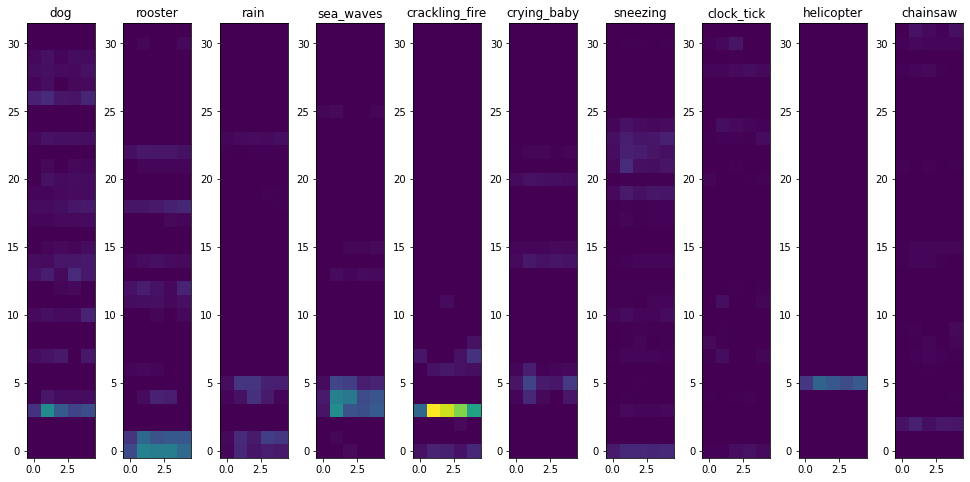

In [28]:
fig, ax = plt.subplots(1, 10,
                       gridspec_kw=dict(left=0.1, right=0.9,
                                        bottom=0.1, top=0.5),
                       figsize=(17, 8))
for j in range(10):
   plt.subplot(1,10,j+1)
   img = grad[:,:,j]*alpha2[:,:,j]
   #print(img.shape)
   plt.imshow((img*(img>np.mean(img))).T, origin='lower', vmin=0, vmax=np.amax(grad*alpha2))
   #plt.imshow((grad[:,:,j]).T, origin='lower', vmin=np.amin(grad), vmax=np.amax(grad))
   plt.title(dataset.label_list[j])    

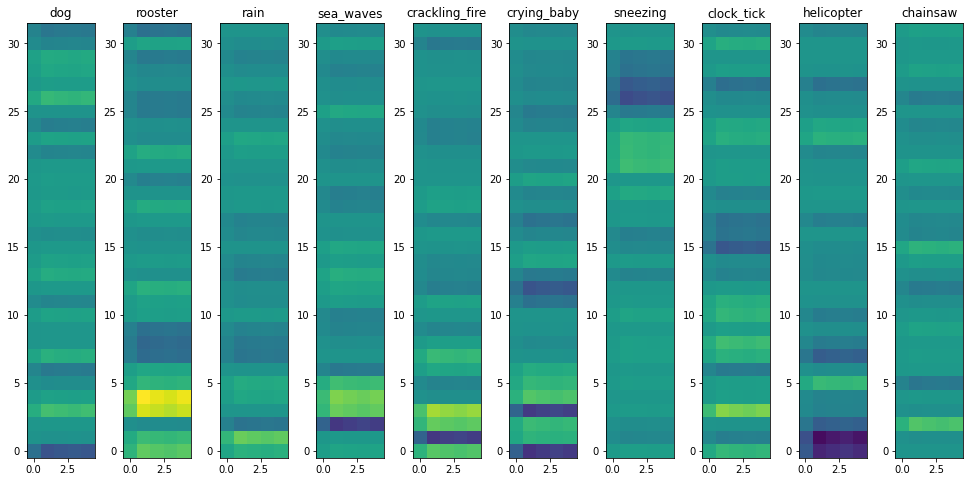

In [29]:
fig, ax = plt.subplots(1, 10,
                       gridspec_kw=dict(left=0.1, right=0.9,
                                        bottom=0.1, top=0.5),
                       figsize=(17, 8))
for j in range(10):
   plt.subplot(1,10,j+1)
   plt.imshow((grad[:,:,j]).T, origin='lower', vmin=np.amin(grad), vmax=np.amax(grad))
   plt.title(dataset.label_list[j])

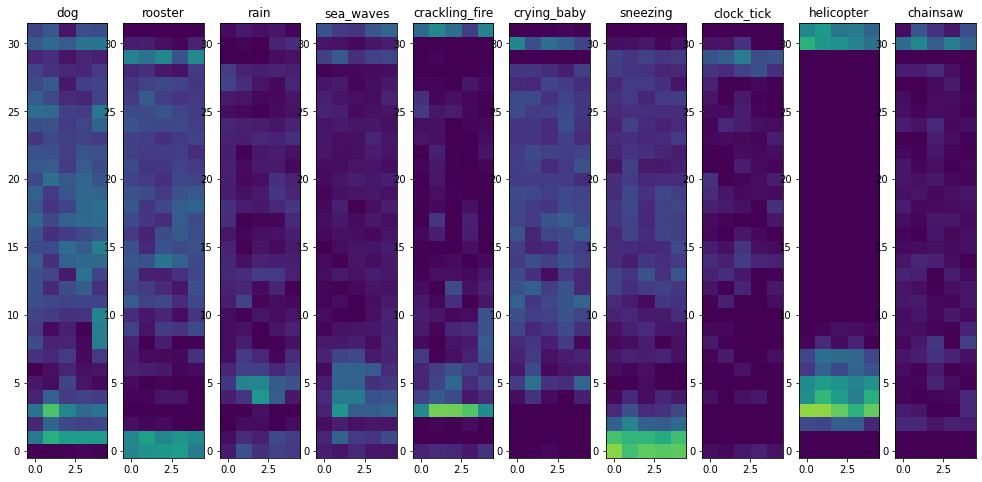

In [30]:
fig, ax = plt.subplots(1, 10,
                       gridspec_kw=dict(left=0.1, right=0.9,
                                        bottom=0.1, top=0.5),
                       figsize=(17, 8))
for j in range(10):
   plt.subplot(1,10,j+1)
   plt.imshow((alpha2[:,:,j]).T, origin='lower', vmin=np.amin(alpha2), vmax=np.amax(alpha2), aspect='auto')
   plt.title(dataset.label_list[j])

Next, we plot attention maps for the top 3 predictions. 

jackhammer
drilling
engine_idling


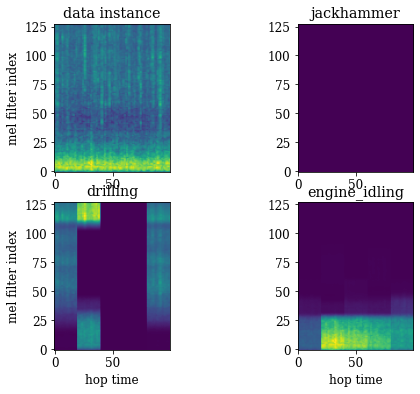

In [31]:
import matplotlib.gridspec as grd

images = []
#get the top-3 classes in terms of predictions
classes_ix = np.argpartition(pred.mean(axis=0), -3)[-3:]

for class_ix in classes_ix:

    print(model_classes[class_ix])

    time_hops = np.argwhere(pred[:,class_ix]*(pred[:,class_ix]>0.5)!=0)

    logits = pred
    mask_logits = np.zeros_like(logits)

    mask_logits[time_hops, class_ix] = 1

    logits = logits*mask_logits

    w = model_container.model.get_layer('dense').get_weights()[0]

    grad = logits.dot(w.T)
    _, C, F = model_container.model.get_layer('sum').output_shape
    grad = np.reshape(grad, (len(logits), C, F))

    alpha2 = np.sum(alpha, axis=1)

    alpha_grad = grad*alpha2
    alpha_grad = alpha_grad*(alpha_grad>0)


    data = np.concatenate(X[instance], axis=0)
    saliency = np.zeros_like(data)

    for th in time_hops:
        energy = np.sum(alpha_grad[th[0]]**2, axis=0)
        profile = alpha_grad[th[0], :, np.argmax(energy)]

        profile_extend = np.interp(np.arange(128), np.arange(32)*4, profile)

        profile_extend = np.convolve(profile_extend, [1/32]*32, mode='same')

        #plt.plot(profile_extend)
        #plt.show()

        saliency[th[0]*20:(th[0] + 1)*20] = profile_extend

    masked_data = 2*((data+1)*saliency/2) - 1
    images.append(np.expand_dims(masked_data, 0))

images = np.concatenate(images, axis=0)
data = np.concatenate(X[instance], axis=0)

plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})

#plt.figure(figsize=(16,4))
plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.imshow(data.T, origin='lower')
plt.title('data instance')
plt.ylabel('mel filter index')
#plt.xlabel('hop time')
plt.subplot(2,2,2)
plt.imshow(images[0].T, origin='lower')
plt.title(model_classes[classes_ix[0]])
#plt.xlabel('hop time')
plt.subplot(2,2,3)
plt.imshow(images[1].T, origin='lower')
plt.title(model_classes[classes_ix[1]])
plt.xlabel('hop time')
plt.ylabel('mel filter index')
plt.subplot(2,2,4)
plt.imshow(images[2].T, origin='lower')
plt.title(model_classes[classes_ix[2]])
plt.xlabel('hop time')
plt.savefig('attention_maps.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)
plt.show()

In [32]:
import librosa
audio = librosa.griffinlim(masked_data)
import IPython.display as ipd
audio = data_gen_test.audio_file_list[instance]['file_original']
sr = params_features['sr']
ipd.Audio(audio,rate=sr)